In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [6]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("iabhishekofficial/mobile-price-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\PC\.cache\kagglehub\datasets\iabhishekofficial\mobile-price-classification\versions\1
Path to dataset files: C:\Users\PC\.cache\kagglehub\datasets\iabhishekofficial\mobile-price-classification\versions\1


In [7]:
import pandas as pd

train = pd.read_csv(os.path.join(path, "train.csv"))
test = pd.read_csv(os.path.join(path, "test.csv"))

print(train.head())
print(test.head())

   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_

#### CSV Dataset

In [8]:
# Load mobile price dataset into dataframe
mobile_df = pd.read_csv(os.path.join(path, "train.csv")).dropna()
print(mobile_df.price_range.unique())
mobile_df.head()

[1 2 3 0]


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [9]:
# Seperate features and target
mb_X = mobile_df.drop(columns=['price_range']).values.astype(np.float32)
mb_y = mobile_df.price_range.values

# Standardize features
scaler = StandardScaler()
mb_X = scaler.fit_transform(mb_X)
# ^^^^^^^^

# Convert to tensors
mb_X = torch.tensor(mb_X)
mb_y = torch.tensor(mb_y)

# Create train and test datasets
mb_train_set = TensorDataset(mb_X, mb_y)
train_split = 0.8
mb_train_size = int(train_split * len(mb_train_set))
mb_test_size = len(mb_train_set) - mb_train_size
mb_train_set, mb_test_set = torch.utils.data.random_split(mb_train_set, [mb_train_size, mb_test_size])

# Create dataloaders
mb_train_loader = DataLoader(mb_train_set, batch_size=16, shuffle=True)
mb_test_loader = DataLoader(mb_test_set, batch_size=16, shuffle=True)

print(len(mb_train_set), len(mb_test_set))
print(len(mb_train_loader), len(mb_test_loader))

1600 400
100 25


#### Functions and Models for use

In [10]:
class MLP_CSV(nn.Module):
    def __init__(self):
        super(MLP_CSV, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=20, out_features=128), # 20 input features
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
        )
        self.out = nn.Linear(in_features=32, out_features=4)  # 4 output for classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

class MLP_MNIST(nn.Module):
    def __init__(self):
        super(MLP_MNIST, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8, out_features=32), # 8*8 = 64 resized input pixels
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=32, out_features=24),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=24, out_features=16),
            nn.ReLU(),
        )
        self.out = nn.Linear(in_features=16, out_features=10)  # 10 output for numbers

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

In [11]:
def training_loop(train_dl, test_dl, model, n_epochs=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Your optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    # ^^^^^^^^

    n_show_loss = n_epochs // 10 if n_epochs > 10 else 1
    train_history = {"train_loss":[], "validate_loss":[],
                     "train_acc":[], "validate_acc":[]}
    # Begin training loop
    for epoch in range(n_epochs):
        # Train loop
        train_loss, train_correct = 0, 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            # This is your training loss calculation
            loss = loss_fn(y_pred, y_t)
            loss.backward()
            # ^^^^^^^^
            optimizer.step()
            train_loss += loss.item()
            train_correct += (y_pred.argmax(1) == y_t).float().sum().item()
        train_history["train_loss"].append(train_loss / len(train_dl))
        train_history["train_acc"].append(train_correct / len(train_dl.dataset))

        # Test loop
        valid_loss, valid_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X_v, y_v in test_dl:
                X_v, y_v = X_v.to(device), y_v.to(device)
                y_predv = model(X_v)
                vloss = loss_fn(y_predv.squeeze(), y_v.squeeze())
                valid_loss += vloss.item()
                valid_correct += (y_predv.argmax(1) == y_v).float().sum().item()
        train_history["validate_loss"].append(valid_loss / len(test_dl))
        train_history["validate_acc"].append(valid_correct / len(test_dl.dataset))

        if ((epoch+1) % n_show_loss == 0) or (epoch == n_epochs-1):
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {train_history['train_loss'][-1]:.6f}",
                  f"valid loss {train_history['validate_loss'][-1]:.6f}",
                  f"train acc {train_history['train_acc'][-1]:.6f}",
                  f"valid acc {train_history['validate_acc'][-1]:.6f}")

    return train_history

def plot_result(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()


----
## HW
----
### - CSV Dataset
Mobile price dataset ที่กำหนดมีข้อมูลเบื้องต้น ดังนี้
- จำนวน Features = 20 (RAM, Internal memory, Battery, ...)
- Target คือ `price_range` โดยมีทั้งหมด 4 ค่า คือ 0, 1, 2, 3 (Low cost, Medium cost, High cost, Very high cost)

> กำหนดให้ใช้โมเดล `MLP_CSV` เป็นต้นแบบ การ train ให้ใช้จำนวน `epochs` = 200, `optimizer` = Adam, `learning_rate` = 0.0001, `train_split` = 0.8, `batch_size` = 16, ไม่ใช้ Learning rate scheduler

'

1.) ให้ทดลอง train โมเดลโดยใช้ training loop ที่ให้มาหรือเขียนขึ้นเอง แบบธรรมดาไม่มีการปรับเพิ่มเติม ใช้เพื่อเป็นผลลัพธ์ Baseline สำหรับข้อต่อ ๆ ไป

- > แคปรูปผลลัพธ์ใหม่ 1 รูป

2.) ให้ทดลอง train โมเดลโดยใช้ L2 Regularizer เพิ่มในข้อ 1.) รวมทั้งหมด 2 แบบ คือ
  1. ใช้ L2 แบบ Marginal loss โดย `lambda` = [0.03, 0.01, 0.005] (เพิ่ม L2 loss ใน Training loop)
  2. ใช้ L2 แบบ Weight decay โดย `weight_decay` = [0.06, 0.01, 0.005] (ปรับ param ใน `optimizer`)

- > แคปรูปผลลัพธ์ใหม่ทั้งหมด 6 รูป พร้อมกับแสดงส่วนที่แก้ไขเพื่อทำ Marginal loss ภายใน Training loop และ วิเคราะห์เปรียบเทียบผลลัพธ์ที่ได้ทั้งหมดกับข้อ 1.)

3.) ให้ทดลอง train โมเดลโดยใช้ Dropout เพิ่มในข้อ 1.) ภายในชั้น fc1, fc2 และ fc3 และแทนค่า `p` ในแต่ละชั้นเป็นค่าดังต่อไปนี้
  1. fc1, fc2, fc3 = 0.5, 0.3, 0.2
  2. fc1, fc2, fc3 = 0.3, 0.2, 0.1
  3. fc1, fc2, fc3 = 0.2, 0.2, 0.2

- > แคปรูปผลลัพธ์ใหม่ทั้งหมด 3 รูป และ วิเคราะห์เปรียบเทียบผลลัพธ์ที่ได้กับข้อ 1.)

4.) ให้ทดลอง train โมเดล `MLP_CSV` ต้นแบบจากข้อ 1.) อีกครั้ง พร้อมกับ train โมเดลที่ใช้ BatchNorm เพิ่มในข้อ 1.) ภายในชั้น fc1, fc2 และ fc3 (ใช้ `nn.BatchNorm1d`) แต่จะมีการปรับในส่วนการเตรียม Mobile price Dataset ดังนี้
  1. โมเดลที่ใช้ BatchNorm ใช้ Dataset ที่ **ผ่าน** การทำ Standardized ด้วย `StandardScaler()` เทียบกับผลลัพธ์ข้อ 1.)
  2. โมเดล `MLP_CSV` ต้นแบบจากข้อ 1.) ใช้ Dataset ที่ **ไม่ผ่าน** การทำ Standardized
  3. โมเดลที่ใช้ BatchNorm ใช้ Dataset ที่ **ไม่ผ่าน** การทำ Standardized เทียบกับผลลัพธ์ข้อ 4.2)

- > แคปรูปผลลัพธ์ใหม่ทั้งหมด 3 รูป และ วิเคราะห์เปรียบเทียบผลลัพธ์ที่ได้

'

----

### - Torchvision Dataset

MNIST dataset จาก torchvision
- ภาพตัวเลขเขียนด้วยลายมือ
- ขนาด 28x28 pixel จะได้จำนวน features = 784
- Target = เลข 0 - 9 (10 ตัว)

```python
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
import ...

# Your own transform
transforms = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                ...,
                ...])

# Optimizer, criterion (loss), and other hyper-pars
# model = ...
# optimizer = ...
# criterion = ...
# batch_size = ...
# scheduler = ...
# other = ...

# Download train-valid(test) Dataset
mnist_train_data = torchvision.datasets.MNIST('./Image/train_directory/', transform=transforms, download=True, train=True)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_data, batch_size=batch_size, shuffle=True)

mnist_test_data = torchvision.datasets.MNIST('./Image/test_directory/', transform=transforms, download=True, train=False)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=True)

# training loop
for epoch in range(epochs):
    model.train()
    # ...
    
    for inputs, labels in mnist_train_loader:
    # or
    for i, (inputs, labels) in enumerate(mnist_train_loader):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      # ...update...

    # Optional
    model.eval()
    with torch.no_grad():
      for vinputs, vlabels in mnist_valid_loader:
      # or
      for j, (vinputs, vlabels) in enumerate(mnist_valid_loader):
      voutputs = model(vinputs)
      loss = criterion(voutputs, vlabels)
      # ...non-update...

```

'

5.) ให้ทำการสร้าง Dataset ที่ใช้การ `transforms` เพิ่มเติมจากที่กำหนดไว้ โดยให้ลดขนาดภาพลงเหลือ 8x8 pixels (64 features) และเพิ่มการ Transform อีกอย่างน้อย 1 แบบ พร้อมกับสร้าง Dataloaders ที่มีจำนวน train : test = 80 : 20 ของจำนวน Dataset ทั้งหมดและใช้ `batch_size` = 16
* > แคปรูปส่วนกำหนดการ transforms และการทำ Dataloaders

ุ6.) ให้ทดลอง train โมเดล `MLP_MNIST` ต้นแบบที่กำหนด และ train โมเดลที่นักศึกษาออกแบบเอง (หรือเพิ่มต่อจากต้นแบบก็ได้) โดยกำหนดให้เพิ่มส่วนเทคนิคการใช้ L2 Regularizer, Dropout และ BatchNorm ภายในโมเดลที่ออกแบบเอง (เลือกอย่างน้อย 2 เทคนิค จะใส่ในทุก Hidden layers หรือไม่ก็ได้)

กำหนดไว้ว่าโมเดลที่นักศึกษาออกแบบ จะสามารถปรับจำนวน features ภายในได้อิสระ แต่ต้องมีจำนวน Hidden layers เท่ากับ `MLP_MNIST` ต้นแบบ และกำหนดการ train จะต้องใช้จำนวน `epochs` เท่ากัน โดยเลือกเองให้ <= 50, `optimizer` เลือกเอง และสามารถใช้ Learning rate scheduler ได้

* > จงทดลองหาผลลัพธ์การทำงาน ที่ทำให้ได้ประสิทธิภาพสูงกว่า `MLP_MNIST` ต้นแบบ เช่น Accuracy สูงกว่าเดิม
>
> แคปรูปผลลัพธ์การทำงาน โครงสร้างโมเดลสุดท้าย และอธิบายว่าใช้เทคนิคอะไร ทำอย่างไรบ้างที่ทำให้ได้ประสิทธิภาพสูงขึ้น

### CSV Task 1: Baseline (Standardized)
Train `MLP_CSV` for 200 epochs with `Adam(lr=1e-4)` on the standardized Mobile Price dataset (`train_split=0.8`, `batch_size=16`). Capture the loss/accuracy curves as the baseline for comparisons.

Epochs 20    train loss 0.167284 valid loss 0.188585 train acc 0.961875 valid acc 0.930000
Epochs 40    train loss 0.066563 valid loss 0.135315 train acc 0.988125 valid acc 0.937500
Epochs 40    train loss 0.066563 valid loss 0.135315 train acc 0.988125 valid acc 0.937500
Epochs 60    train loss 0.028134 valid loss 0.137758 train acc 0.998750 valid acc 0.940000
Epochs 60    train loss 0.028134 valid loss 0.137758 train acc 0.998750 valid acc 0.940000
Epochs 80    train loss 0.010369 valid loss 0.157868 train acc 1.000000 valid acc 0.940000
Epochs 80    train loss 0.010369 valid loss 0.157868 train acc 1.000000 valid acc 0.940000
Epochs 100   train loss 0.003515 valid loss 0.175951 train acc 1.000000 valid acc 0.942500
Epochs 100   train loss 0.003515 valid loss 0.175951 train acc 1.000000 valid acc 0.942500
Epochs 120   train loss 0.001135 valid loss 0.202698 train acc 1.000000 valid acc 0.940000
Epochs 120   train loss 0.001135 valid loss 0.202698 train acc 1.000000 valid acc 0.940000

C:\Users\PC\AppData\Local\Temp\ipykernel_27656\1139490047.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


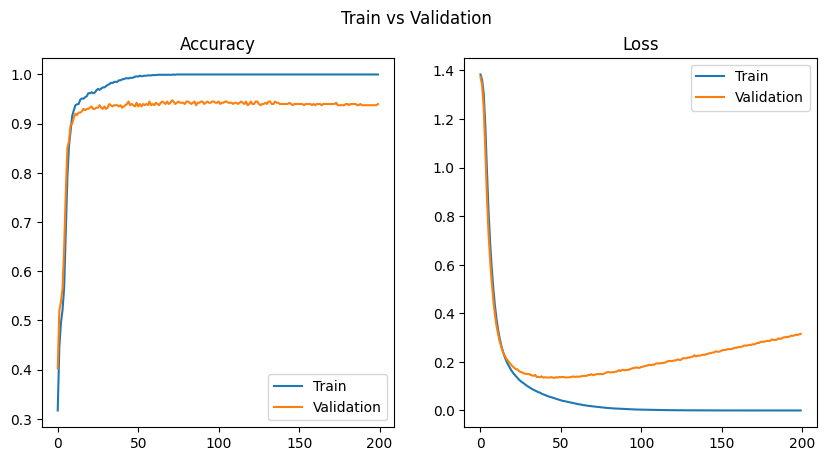

In [12]:
# Baseline training on standardized data
np.random.seed(42)
torch.manual_seed(42)

baseline_model = MLP_CSV()
base_hist = training_loop(mb_train_loader, mb_test_loader, baseline_model, n_epochs=200)
plot_result(base_hist)

### CSV Task 2: L2 Regularization
Run two variants using the standardized loaders: (a) Marginal L2 loss with `lambda in [0.03, 0.01, 0.005]`; (b) Optimizer `weight_decay` with `[0.06, 0.01, 0.005]`. For (a), we add an L2 term into the training loss; for (b), we pass `weight_decay` to `Adam`.


[Marginal L2] lambda=0.03
epoch  20 | train_loss 1.1845 | val_loss 0.7209 | val_acc 0.7200
epoch  20 | train_loss 1.1845 | val_loss 0.7209 | val_acc 0.7200
epoch  40 | train_loss 0.9972 | val_loss 0.4384 | val_acc 0.9400
epoch  40 | train_loss 0.9972 | val_loss 0.4384 | val_acc 0.9400
epoch  60 | train_loss 0.9711 | val_loss 0.3814 | val_acc 0.9450
epoch  60 | train_loss 0.9711 | val_loss 0.3814 | val_acc 0.9450
epoch  80 | train_loss 0.9660 | val_loss 0.3681 | val_acc 0.9550
epoch  80 | train_loss 0.9660 | val_loss 0.3681 | val_acc 0.9550
epoch 100 | train_loss 0.9630 | val_loss 0.3661 | val_acc 0.9575
epoch 100 | train_loss 0.9630 | val_loss 0.3661 | val_acc 0.9575
epoch 120 | train_loss 0.9612 | val_loss 0.3606 | val_acc 0.9525
epoch 120 | train_loss 0.9612 | val_loss 0.3606 | val_acc 0.9525
epoch 140 | train_loss 0.9602 | val_loss 0.3607 | val_acc 0.9600
epoch 140 | train_loss 0.9602 | val_loss 0.3607 | val_acc 0.9600
epoch 160 | train_loss 0.9592 | val_loss 0.3569 | val_acc 0.952

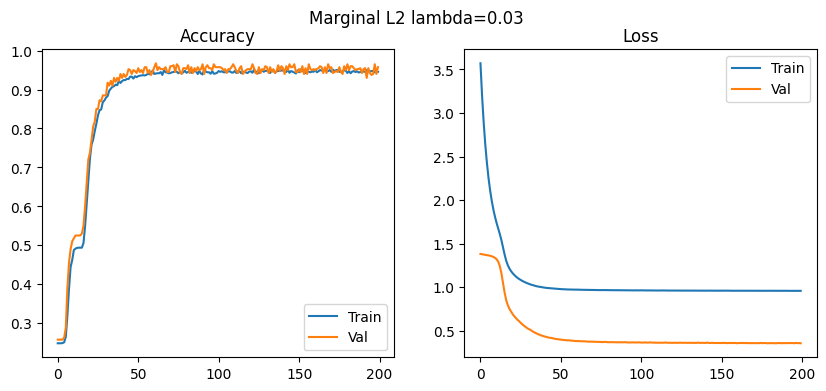

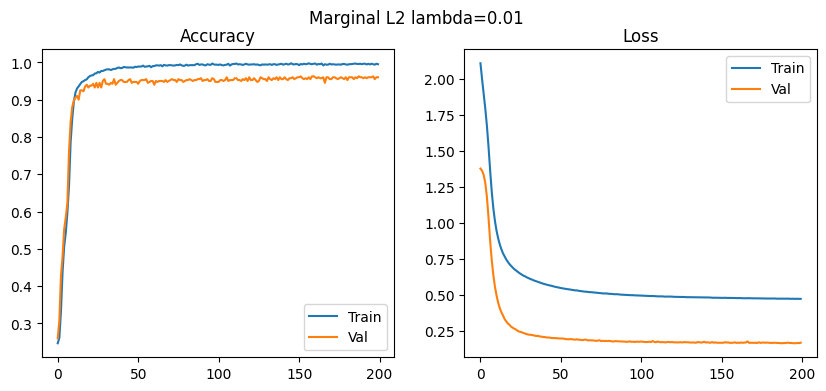

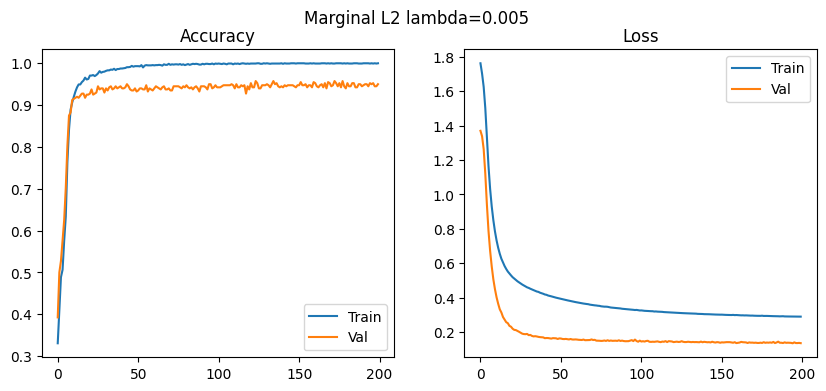


[Weight Decay] weight_decay=0.06
epoch  20 | train_loss 0.7423 | val_loss 0.7035 | val_acc 0.7375
epoch  20 | train_loss 0.7423 | val_loss 0.7035 | val_acc 0.7375
epoch  40 | train_loss 0.4642 | val_loss 0.4461 | val_acc 0.9400
epoch  40 | train_loss 0.4642 | val_loss 0.4461 | val_acc 0.9400
epoch  60 | train_loss 0.4090 | val_loss 0.3910 | val_acc 0.9525
epoch  60 | train_loss 0.4090 | val_loss 0.3910 | val_acc 0.9525
epoch  80 | train_loss 0.3938 | val_loss 0.3781 | val_acc 0.9400
epoch  80 | train_loss 0.3938 | val_loss 0.3781 | val_acc 0.9400
epoch 100 | train_loss 0.3893 | val_loss 0.3707 | val_acc 0.9525
epoch 100 | train_loss 0.3893 | val_loss 0.3707 | val_acc 0.9525
epoch 120 | train_loss 0.3860 | val_loss 0.3689 | val_acc 0.9550
epoch 120 | train_loss 0.3860 | val_loss 0.3689 | val_acc 0.9550
epoch 140 | train_loss 0.3841 | val_loss 0.3668 | val_acc 0.9425
epoch 140 | train_loss 0.3841 | val_loss 0.3668 | val_acc 0.9425
epoch 160 | train_loss 0.3812 | val_loss 0.3636 | val_ac

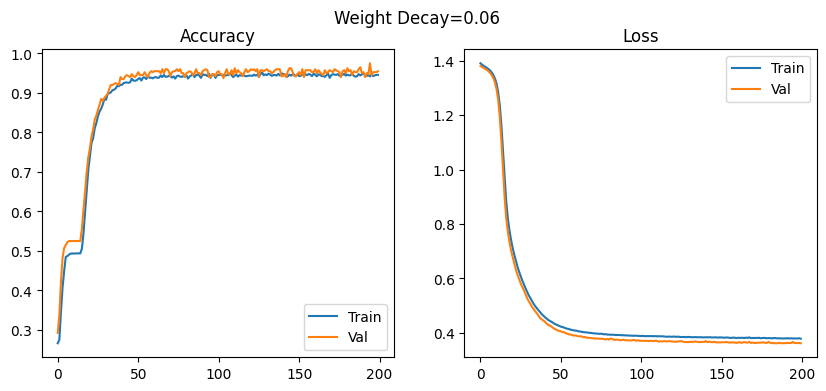

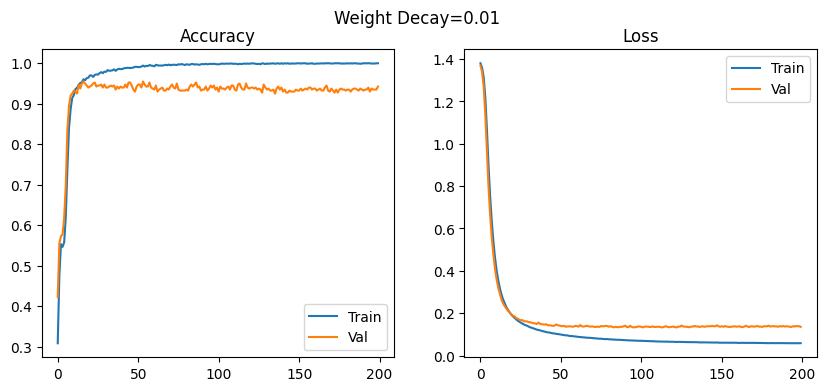

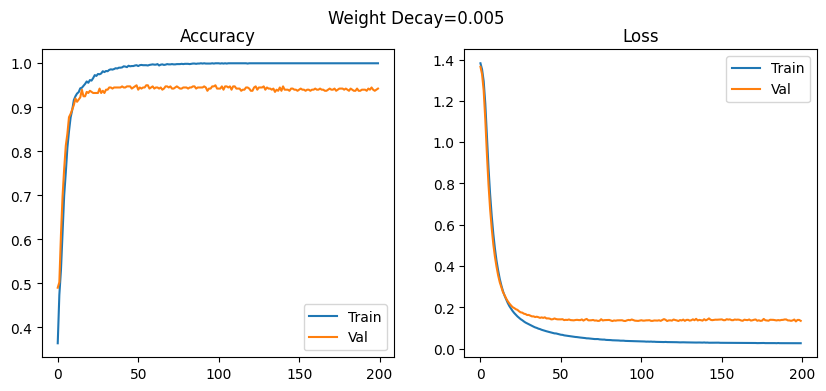

In [13]:
def l2_marginal_loss(model, lam):
    l2 = 0.0
    for p in model.parameters():
        l2 = l2 + p.pow(2).sum()
    return lam * l2

# (a) Marginal L2
lambdas = [0.03, 0.01, 0.005]
hist_l2_marginal = {}
for lam in lambdas:
    print(f"\n[Marginal L2] lambda={lam}")
    model = MLP_CSV()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    n_epochs = 200

    history = {"train_loss":[], "validate_loss":[], "train_acc":[], "validate_acc":[]}
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss, train_correct, n_train = 0.0, 0, 0
        for xb, yb in mb_train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb) + l2_marginal_loss(model, lam)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (logits.argmax(1) == yb).sum().item()
            n_train += yb.size(0)
        history["train_loss"].append(train_loss / len(mb_train_loader))
        history["train_acc"].append(train_correct / n_train)
        # Valid
        model.eval()
        valid_loss, valid_correct, n_valid = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in mb_test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                vloss = loss_fn(logits, yb)
                valid_loss += vloss.item()
                valid_correct += (logits.argmax(1) == yb).sum().item()
                n_valid += yb.size(0)
        history["validate_loss"].append(valid_loss / len(mb_test_loader))
        history["validate_acc"].append(valid_correct / n_valid)
        if (epoch+1) % 20 == 0:
            print(f"epoch {epoch+1:3d} | train_loss {history['train_loss'][-1]:.4f} | val_loss {history['validate_loss'][-1]:.4f} | val_acc {history['validate_acc'][-1]:.4f}")
    hist_l2_marginal[lam] = history

# Plot
for lam, hist in hist_l2_marginal.items():
    plt.figure(figsize=(10,4))
    plt.suptitle(f"Marginal L2 lambda={lam}")
    plt.subplot(1,2,1); plt.plot(hist["train_acc"], label="Train"); plt.plot(hist["validate_acc"], label="Val"); plt.title("Accuracy"); plt.legend()
    plt.subplot(1,2,2); plt.plot(hist["train_loss"], label="Train"); plt.plot(hist["validate_loss"], label="Val"); plt.title("Loss"); plt.legend()
    plt.show()

# (b) Weight decay
wds = [0.06, 0.01, 0.005]
hist_l2_wd = {}
for wd in wds:
    print(f"\n[Weight Decay] weight_decay={wd}")
    model = MLP_CSV()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()
    n_epochs = 200

    history = {"train_loss":[], "validate_loss":[], "train_acc":[], "validate_acc":[]}
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_correct, n_train = 0.0, 0, 0
        for xb, yb in mb_train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (logits.argmax(1) == yb).sum().item()
            n_train += yb.size(0)
        history["train_loss"].append(train_loss / len(mb_train_loader))
        history["train_acc"].append(train_correct / n_train)

        model.eval()
        valid_loss, valid_correct, n_valid = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in mb_test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                vloss = loss_fn(logits, yb)
                valid_loss += vloss.item()
                valid_correct += (logits.argmax(1) == yb).sum().item()
                n_valid += yb.size(0)
        history["validate_loss"].append(valid_loss / len(mb_test_loader))
        history["validate_acc"].append(valid_correct / n_valid)
        if (epoch+1) % 20 == 0:
            print(f"epoch {epoch+1:3d} | train_loss {history['train_loss'][-1]:.4f} | val_loss {history['validate_loss'][-1]:.4f} | val_acc {history['validate_acc'][-1]:.4f}")
    hist_l2_wd[wd] = history

for wd, hist in hist_l2_wd.items():
    plt.figure(figsize=(10,4))
    plt.suptitle(f"Weight Decay={wd}")
    plt.subplot(1,2,1); plt.plot(hist["train_acc"], label="Train"); plt.plot(hist["validate_acc"], label="Val"); plt.title("Accuracy"); plt.legend()
    plt.subplot(1,2,2); plt.plot(hist["train_loss"], label="Train"); plt.plot(hist["validate_loss"], label="Val"); plt.title("Loss"); plt.legend()
    plt.show()

### CSV Task 3: Dropout variants
Create a Dropout-enabled model and train with three `p` settings for `(fc1, fc2, fc3)`: (0.5,0.3,0.2), (0.3,0.2,0.1), (0.2,0.2,0.2).


[Dropout] p=(0.5,0.3,0.2)
epoch  20 | val_acc 0.9000
epoch  20 | val_acc 0.9000
epoch  40 | val_acc 0.9350
epoch  40 | val_acc 0.9350
epoch  60 | val_acc 0.9350
epoch  60 | val_acc 0.9350
epoch  80 | val_acc 0.9350
epoch  80 | val_acc 0.9350
epoch 100 | val_acc 0.9375
epoch 100 | val_acc 0.9375
epoch 120 | val_acc 0.9400
epoch 120 | val_acc 0.9400
epoch 140 | val_acc 0.9425
epoch 140 | val_acc 0.9425
epoch 160 | val_acc 0.9400
epoch 160 | val_acc 0.9400
epoch 180 | val_acc 0.9425
epoch 180 | val_acc 0.9425
epoch 200 | val_acc 0.9425
epoch 200 | val_acc 0.9425


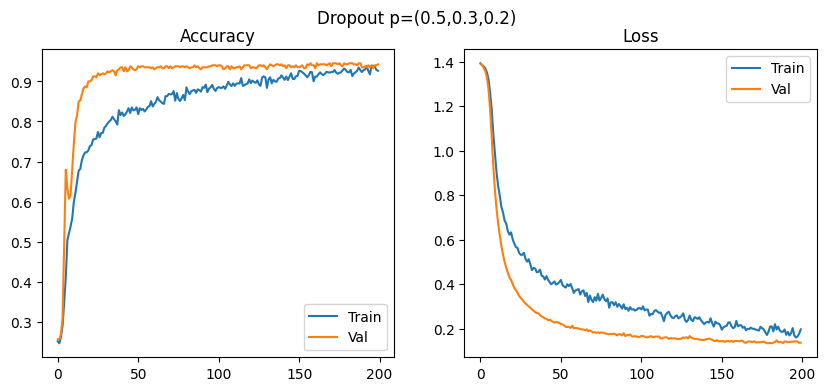


[Dropout] p=(0.3,0.2,0.1)
epoch  20 | val_acc 0.9200
epoch  20 | val_acc 0.9200
epoch  40 | val_acc 0.9375
epoch  40 | val_acc 0.9375
epoch  60 | val_acc 0.9325
epoch  60 | val_acc 0.9325
epoch  80 | val_acc 0.9350
epoch  80 | val_acc 0.9350
epoch 100 | val_acc 0.9325
epoch 100 | val_acc 0.9325
epoch 120 | val_acc 0.9350
epoch 120 | val_acc 0.9350
epoch 140 | val_acc 0.9325
epoch 140 | val_acc 0.9325
epoch 160 | val_acc 0.9450
epoch 160 | val_acc 0.9450
epoch 180 | val_acc 0.9400
epoch 180 | val_acc 0.9400
epoch 200 | val_acc 0.9450
epoch 200 | val_acc 0.9450


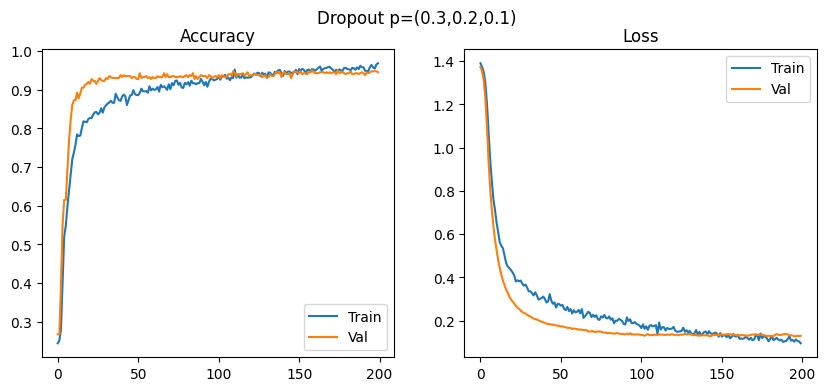


[Dropout] p=(0.2,0.2,0.2)
epoch  20 | val_acc 0.9050
epoch  20 | val_acc 0.9050
epoch  40 | val_acc 0.9400
epoch  40 | val_acc 0.9400
epoch  60 | val_acc 0.9275
epoch  60 | val_acc 0.9275
epoch  80 | val_acc 0.9400
epoch  80 | val_acc 0.9400
epoch 100 | val_acc 0.9350
epoch 100 | val_acc 0.9350
epoch 120 | val_acc 0.9400
epoch 120 | val_acc 0.9400
epoch 140 | val_acc 0.9350
epoch 140 | val_acc 0.9350
epoch 160 | val_acc 0.9350
epoch 160 | val_acc 0.9350
epoch 180 | val_acc 0.9325
epoch 180 | val_acc 0.9325
epoch 200 | val_acc 0.9375
epoch 200 | val_acc 0.9375


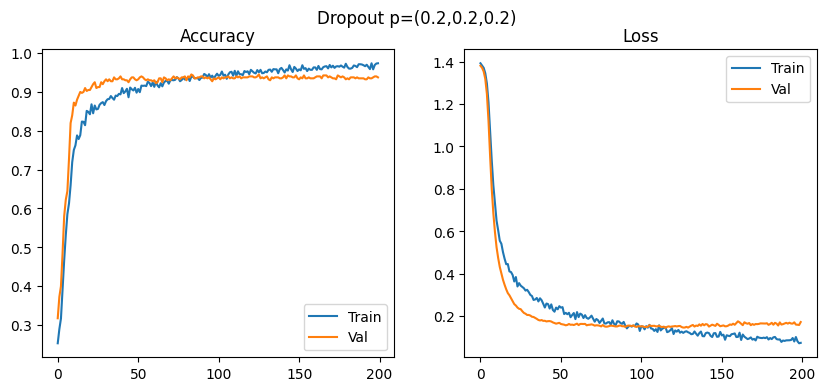

In [14]:
class MLP_CSV_Dropout(nn.Module):
    def __init__(self, p1=0.5, p2=0.3, p3=0.2):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(20, 128), nn.ReLU(), nn.Dropout(p1)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p2)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p3)
        )
        self.out = nn.Linear(32, 4)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.out(x)

def train_simple(train_dl, test_dl, model, n_epochs=200, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    hist = {"train_loss":[], "validate_loss":[], "train_acc":[], "validate_acc":[]}
    for ep in range(n_epochs):
        model.train(); tl, tc, nt = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); logits = model(xb); loss = loss_fn(logits, yb)
            loss.backward(); opt.step()
            tl += loss.item(); tc += (logits.argmax(1)==yb).sum().item(); nt += yb.size(0)
        hist["train_loss"].append(tl/len(train_dl)); hist["train_acc"].append(tc/nt)
        model.eval(); vl, vc, nv = 0.0,0,0
        with torch.no_grad():
            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb); loss = loss_fn(logits, yb)
                vl += loss.item(); vc += (logits.argmax(1)==yb).sum().item(); nv += yb.size(0)
        hist["validate_loss"].append(vl/len(test_dl)); hist["validate_acc"].append(vc/nv)
        if (ep+1)%20==0:
            print(f"epoch {ep+1:3d} | val_acc {hist['validate_acc'][-1]:.4f}")
    return hist

p_sets = [(0.5,0.3,0.2),(0.3,0.2,0.1),(0.2,0.2,0.2)]
hist_dropout = {}
for p1,p2,p3 in p_sets:
    print(f"\n[Dropout] p=({p1},{p2},{p3})")
    model = MLP_CSV_Dropout(p1,p2,p3)
    hist = train_simple(mb_train_loader, mb_test_loader, model, n_epochs=200, lr=1e-4)
    hist_dropout[(p1,p2,p3)] = hist
    plt.figure(figsize=(10,4))
    plt.suptitle(f"Dropout p=({p1},{p2},{p3})")
    plt.subplot(1,2,1); plt.plot(hist["train_acc"], label="Train"); plt.plot(hist["validate_acc"], label="Val"); plt.title("Accuracy"); plt.legend()
    plt.subplot(1,2,2); plt.plot(hist["train_loss"], label="Train"); plt.plot(hist["validate_loss"], label="Val"); plt.title("Loss"); plt.legend()
    plt.show()

### CSV Task 4: BatchNorm vs Standardization
We compare (1) BN model on standardized data; (2) Baseline model on non-standardized data; (3) BN model on non-standardized data.


[4.1] BN with standardized data
epoch  20 | val_acc 0.8650
epoch  20 | val_acc 0.8650
epoch  40 | val_acc 0.8950
epoch  40 | val_acc 0.8950
epoch  60 | val_acc 0.8700
epoch  60 | val_acc 0.8700
epoch  80 | val_acc 0.8475
epoch  80 | val_acc 0.8475
epoch 100 | val_acc 0.8600
epoch 100 | val_acc 0.8600
epoch 120 | val_acc 0.8150
epoch 120 | val_acc 0.8150
epoch 140 | val_acc 0.8050
epoch 140 | val_acc 0.8050
epoch 160 | val_acc 0.7825
epoch 160 | val_acc 0.7825
epoch 180 | val_acc 0.7550
epoch 180 | val_acc 0.7550
epoch 200 | val_acc 0.7700

[4.2] Baseline without standardization
epoch 200 | val_acc 0.7700

[4.2] Baseline without standardization


C:\Users\PC\AppData\Local\Temp\ipykernel_27656\1139490047.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


epoch  20 | val_acc 0.6275
epoch  40 | val_acc 0.6475
epoch  40 | val_acc 0.6475
epoch  60 | val_acc 0.6675
epoch  60 | val_acc 0.6675
epoch  80 | val_acc 0.6600
epoch  80 | val_acc 0.6600
epoch 100 | val_acc 0.6775
epoch 100 | val_acc 0.6775
epoch 120 | val_acc 0.6750
epoch 120 | val_acc 0.6750
epoch 140 | val_acc 0.7225
epoch 140 | val_acc 0.7225
epoch 160 | val_acc 0.7225
epoch 160 | val_acc 0.7225
epoch 180 | val_acc 0.6725
epoch 180 | val_acc 0.6725
epoch 200 | val_acc 0.7300

[4.3] BN without standardization
epoch 200 | val_acc 0.7300

[4.3] BN without standardization
epoch  20 | val_acc 0.9525
epoch  20 | val_acc 0.9525
epoch  40 | val_acc 0.9350
epoch  40 | val_acc 0.9350
epoch  60 | val_acc 0.9575
epoch  60 | val_acc 0.9575
epoch  80 | val_acc 0.9550
epoch  80 | val_acc 0.9550
epoch 100 | val_acc 0.9650
epoch 100 | val_acc 0.9650
epoch 120 | val_acc 0.9475
epoch 120 | val_acc 0.9475
epoch 140 | val_acc 0.9550
epoch 140 | val_acc 0.9550
epoch 160 | val_acc 0.9325
epoch 160 | va

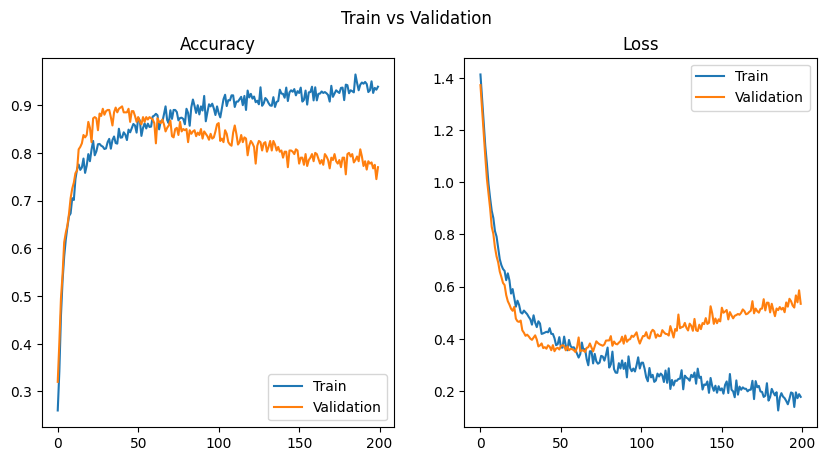

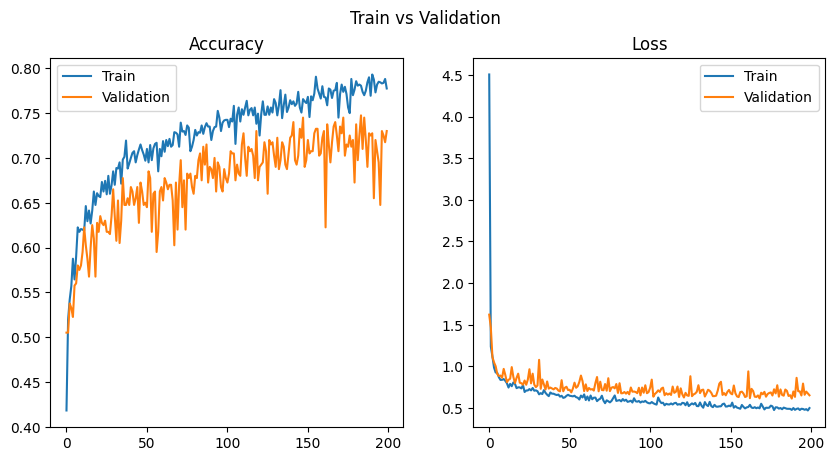

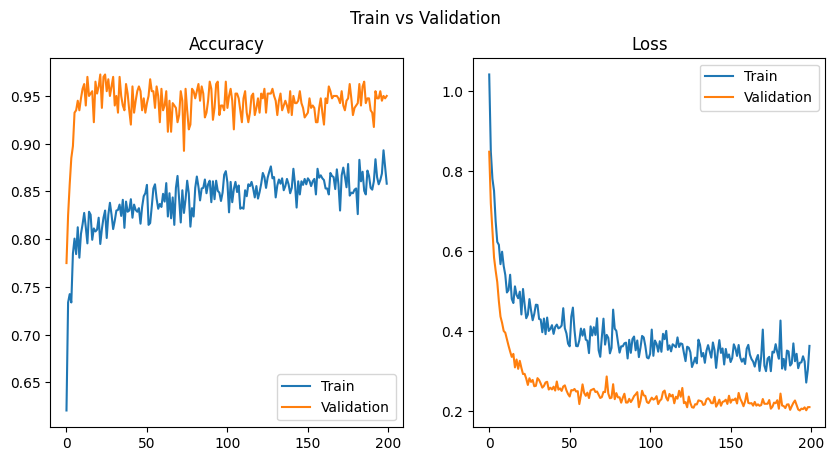

In [15]:
# Build non-standardized loaders from the original train DataFrame
mobile_df_ns = pd.read_csv(os.path.join(path, "train.csv")).dropna()
X_ns = mobile_df_ns.drop(columns=['price_range']).values.astype(np.float32)
y_ns = mobile_df_ns.price_range.values
X_ns_t = torch.tensor(X_ns)
y_ns_t = torch.tensor(y_ns)
ns_dataset = TensorDataset(X_ns_t, y_ns_t)
ns_train_size = int(0.8 * len(ns_dataset))
ns_test_size = len(ns_dataset) - ns_train_size
ns_train_set, ns_test_set = torch.utils.data.random_split(ns_dataset, [ns_train_size, ns_test_size])
ns_train_loader = DataLoader(ns_train_set, batch_size=16, shuffle=True)
ns_test_loader = DataLoader(ns_test_set, batch_size=16, shuffle=True)

class MLP_CSV_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(nn.Linear(20,128), nn.BatchNorm1d(128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,64), nn.BatchNorm1d(64), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(64,32), nn.BatchNorm1d(32), nn.ReLU())
        self.out = nn.Linear(32,4)
    def forward(self, x):
        x = self.fc1(x); x = self.fc2(x); x = self.fc3(x); return self.out(x)

# 4.1 BN + standardized
print("\n[4.1] BN with standardized data")
model_41 = MLP_CSV_BN()
h41 = train_simple(mb_train_loader, mb_test_loader, model_41, n_epochs=200, lr=1e-4)
plot_result(h41)

# 4.2 Baseline (no BN) on non-standardized
print("\n[4.2] Baseline without standardization")
model_42 = MLP_CSV()
h42 = train_simple(ns_train_loader, ns_test_loader, model_42, n_epochs=200, lr=1e-4)
plot_result(h42)

# 4.3 BN on non-standardized
print("\n[4.3] BN without standardization")
model_43 = MLP_CSV_BN()
h43 = train_simple(ns_train_loader, ns_test_loader, model_43, n_epochs=200, lr=1e-4)
plot_result(h43)

### Torchvision Task 5: Transforms and Dataloaders (80:20, batch_size=16)
Create transforms that (a) resize images to 8x8 and (b) add at least one more transform. Then build DataLoaders with train:test = 80:20 and batch_size = 16.

In [16]:
# MNIST transforms to 8x8 + extra transform, and 80:20 loaders
import torchvision

# Prefer transforms.v2 when available, else fallback to classic transforms
try:
    from torchvision.transforms import v2 as T
    use_v2 = True
except Exception:
    from torchvision import transforms as T
    use_v2 = False

# Compose transforms: Resize to 8x8 and add RandomRotation as extra augmentation
if use_v2:
    mnist_transform = T.Compose([
        T.ToImage(),
        T.Resize((8, 8)),
        T.RandomRotation(10),
        T.ToDtype(torch.float32, scale=True),  # scales to [0,1] float32
    ])
else:
    mnist_transform = T.Compose([
        T.Resize((8, 8)),
        T.RandomRotation(10),
        T.ToTensor(),  # already float32 in [0,1]
    ])

# Download and combine full MNIST (train+test), then split 80:20
full_train = torchvision.datasets.MNIST('./Image/mnist/', transform=mnist_transform, download=True, train=True)
full_test = torchvision.datasets.MNIST('./Image/mnist/', transform=mnist_transform, download=True, train=False)
full_dataset = torch.utils.data.ConcatDataset([full_train, full_test])

mnist_train_size = int(0.8 * len(full_dataset))
mnist_valid_size = len(full_dataset) - mnist_train_size
mnist_train_set, mnist_valid_set = torch.utils.data.random_split(full_dataset, [mnist_train_size, mnist_valid_size])

mnist_batch_size = 16
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=mnist_batch_size, shuffle=True)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid_set, batch_size=mnist_batch_size, shuffle=True)

len(mnist_train_set), len(mnist_valid_set), len(mnist_train_loader), len(mnist_valid_loader)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.59MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 107kB/s]

100%|██████████| 1.65M/1.65M [00:01<00:00, 1.05MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 16.5MB/s]



(56000, 14000, 3500, 875)

### Torchvision Task 6: Train `MLP_MNIST` baseline and an improved model
- Use the same number of hidden layers as the baseline.
- Add at least two techniques among L2, Dropout, BatchNorm to the improved model.
- Use the same number of epochs (<= 50) for both models and compare results.

epoch  5 | val_acc 0.9257
epoch 10 | val_acc 0.9470
epoch 10 | val_acc 0.9470
epoch 15 | val_acc 0.9536
epoch 15 | val_acc 0.9536
epoch 20 | val_acc 0.9557
epoch 20 | val_acc 0.9557
epoch 25 | val_acc 0.9549
epoch 25 | val_acc 0.9549
epoch 30 | val_acc 0.9615
epoch 30 | val_acc 0.9615


C:\Users\PC\AppData\Local\Temp\ipykernel_27656\1139490047.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


epoch  5 | val_acc 0.9544
epoch 10 | val_acc 0.9579
epoch 10 | val_acc 0.9579
epoch 15 | val_acc 0.9621
epoch 15 | val_acc 0.9621
epoch 20 | val_acc 0.9643
epoch 20 | val_acc 0.9643
epoch 25 | val_acc 0.9620
epoch 25 | val_acc 0.9620
epoch 30 | val_acc 0.9656
Baseline final val acc: 0.9615
Improved final val acc: 0.9656428571428571
epoch 30 | val_acc 0.9656
Baseline final val acc: 0.9615
Improved final val acc: 0.9656428571428571


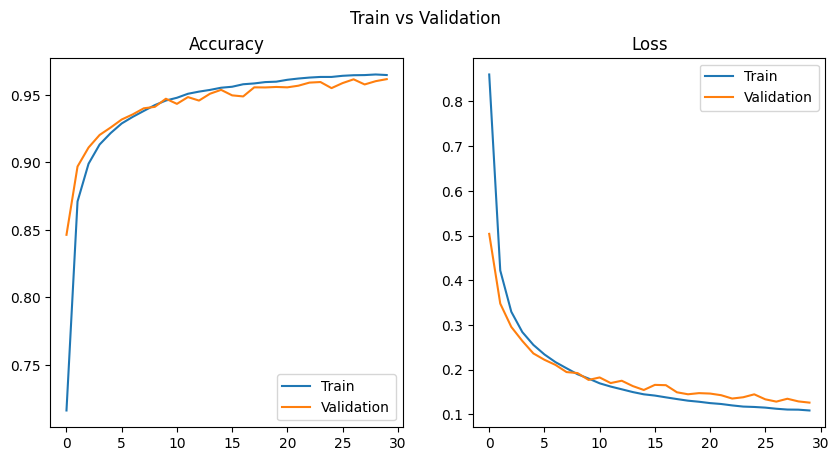

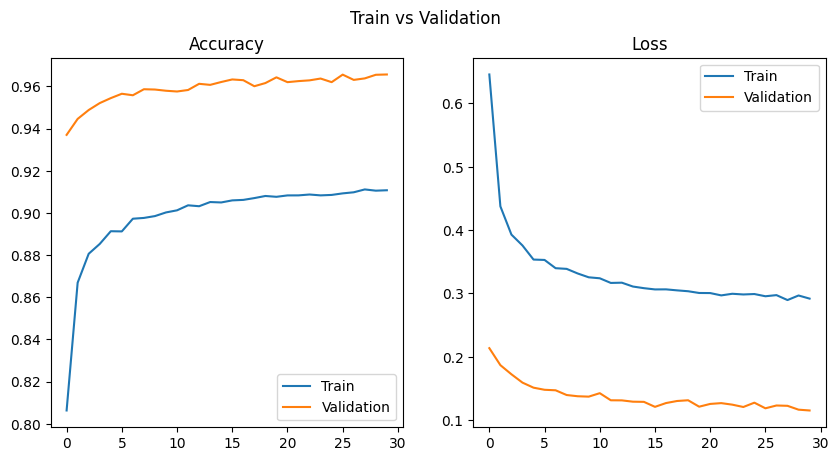

In [17]:
# Helper: simple training with optional weight decay for MNIST

def train_simple_wd(train_dl, valid_dl, model, n_epochs=30, lr=1e-3, weight_decay=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    hist = {"train_loss":[], "validate_loss":[], "train_acc":[], "validate_acc":[]}
    for ep in range(n_epochs):
        model.train(); tl, tc, nt = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); logits = model(xb); loss = loss_fn(logits, yb)
            loss.backward(); opt.step()
            tl += loss.item(); tc += (logits.argmax(1)==yb).sum().item(); nt += yb.size(0)
        hist["train_loss"].append(tl/len(train_dl)); hist["train_acc"].append(tc/nt)
        model.eval(); vl, vc, nv = 0.0,0,0
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb); loss = loss_fn(logits, yb)
                vl += loss.item(); vc += (logits.argmax(1)==yb).sum().item(); nv += yb.size(0)
        hist["validate_loss"].append(vl/len(valid_dl)); hist["validate_acc"].append(vc/nv)
        if (ep+1)%5==0:
            print(f"epoch {ep+1:2d} | val_acc {hist['validate_acc'][-1]:.4f}")
    return hist

# Baseline training (uses provided MLP_MNIST)
mnist_epochs = 30  # <= 50 and same for both models
mnist_lr = 1e-3

mnist_model_base = MLP_MNIST()
h_mnist_base = train_simple_wd(mnist_train_loader, mnist_valid_loader, mnist_model_base, n_epochs=mnist_epochs, lr=mnist_lr, weight_decay=0.0)
plot_result(h_mnist_base)

# Improved model with BN + Dropout + L2 (weight decay)
class MLP_MNIST_Improved(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(48, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.out = nn.Linear(32, 10)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.out(x)

mnist_model_improved = MLP_MNIST_Improved()
h_mnist_improved = train_simple_wd(mnist_train_loader, mnist_valid_loader, mnist_model_improved, n_epochs=mnist_epochs, lr=mnist_lr, weight_decay=1e-4)
plot_result(h_mnist_improved)

# Quick comparison printout
print("Baseline final val acc:", h_mnist_base['validate_acc'][-1])
print("Improved final val acc:", h_mnist_improved['validate_acc'][-1])